Homework 1 Problem 3
===== 

Problem 3 A
------

In [1]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os

from IPython.display import Image

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# get chemkin file and setup reactor
cti_file = '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/propanepyrolysis.cti'
gas = ct.Solution(cti_file)

# 1 ppmv, if it is ideal gas, will just be molar ratio. therefor mole fractions will be:
X_H = 1/(1e6+1)
X_Prop = 1e6/(1e6+1)

# Reactor conditions
reactorTemperature = 1000  # Kelvin
reactorPressure = ct.one_atm
concentrations = {'H(2)': X_H, 'propane(1)': X_Prop}
gas.TPX = reactorTemperature, reactorPressure, concentrations 
H_conc = gas['H(2)'].concentrations
H_conc_half = H_conc/2
Prop_conc = gas['propane(1)'].concentrations

print(Prop_conc)
#initialize reactor, reactor network and sensitivities
atol = 1e-23
rtol = 1e-8
r1 = ct.ConstPressureReactor(contents=gas, energy='off', name='isothermal_reactor')

sim = ct.ReactorNet([r1])
sim.atol = atol
sim.rtol = rtol
print(gas.n_reactions)
for i in range(gas.n_reactions):
     r1.add_sensitivity_reaction(i)

#check initial concentration
print(*gas['H(2)','propane(1)'].X)
print(H_conc, H_conc_half)

[0.01218658]
668
9.99999000001e-07 0.9999990000009998
[1.21865849e-08] [6.09329247e-09]


In [3]:
# Run the reactor
time = 1e-2
sim.reinitialize()

# make a second file for net rates of progress (kmol/M^3)
gas.net_rates_of_progress

# Create output files for sim that we can read in later:
outfile = open('results_propane','w')
outfile2 = open('results_propane_ROP','w')
outfile3 = open('results__propane_sensitivity', 'w')
gas_production_label = [s + ' production rate' for s in gas.species_names]
gas_concentration_label = [s + ' concentration' for s in gas.species_names]
writer = csv.writer(outfile)
writer2 = csv.writer(outfile2)
writer3 = csv.writer(outfile3)
writer.writerow(['Time (s)'] + gas.species_names + gas_concentration_label + gas_production_label)
writer2.writerow(['Time (s)'] + gas.reactions())
writer3.writerow(['Time (s)'] + gas.reactions())

while sim.time < time:
    sim.step()
    writer.writerow([sim.time] + list(gas.X) + list(gas.concentrations)+list(gas.net_production_rates))
    writer2.writerow([sim.time] + list(gas.net_rates_of_progress))
    writer3.writerow([sim.time] + [sim.sensitivity('H(2)', s) for s in range(gas.n_reactions)])

In [4]:
data = pd.read_csv('results_propane')
df = pd.DataFrame(data)
data_rop = pd.read_csv('results_propane_ROP')
df_rop = pd.DataFrame(data_rop)
data_sens = pd.read_csv('results__propane_sensitivity')
df_sens = pd.DataFrame(data_sens)

In [5]:
# find first concentration of H atom below 5e-7

timecol = df[df.columns[0]]
Hcol = df['H(2) concentration']

for i in range (0, len(timecol)):
    if Hcol[i] <= H_conc_half:
        # perform 2-point interpolation to get half life time
        y1 = timecol[i-1]
        y2 = timecol[i]
        x1 = Hcol[i-1]
        x2 = Hcol[i]
        t_halflife = ((y2-y1)/(x2-x1))*(H_conc_half-x1)+y1
        print("Halflife of H radical is", t_halflife, "seconds")
        break
        


Halflife of H radical is [1.51047098e-08] seconds


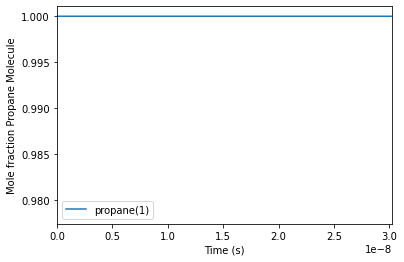

In [6]:
# Does the mole fraction of ethane change much on this short timescale? 

# lets see. We'll set the max of the x-axis to t_halflife for the ethane mole fraction:
plt1 = data.plot(x='Time (s)', y='propane(1)')
plt1.set_xlim(0,t_halflife *2)
plt.ylabel('Mole fraction Propane Molecule')
plt.xlabel('Time (s)')
plt.show()

# it appears that it does not change very much from 0 to t_halflife

In [7]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CH':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CH':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))

In [8]:
save_flux_diagrams(gas)

Wrote graphviz input file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_C_gas.dot'.
Wrote graphviz output file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_C_gas.png'.
Wrote graphviz input file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_H_gas.dot'.
Wrote graphviz output file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_H_gas.png'.


##### Problem 3.A.i #####

As in Problem 1, consider what happens at short times if a small amount of H atom is introduced into pure propane. In this case, there are two competing reactions

i) what are they? 

it appears that we have these reactions occurring over our smaller timescale (see cell below): 

Reaction 28<br>
H(2) + propane(1) <=> H2(6) + IC3H7(93) Max = 0.3225451757

Reaction 29<br>
H(2) + propane(1) <=> H2(6) + NC3H7(92) Max = 0.2371216017

In [9]:
# add check to find species that go above a threshold value of mole fraction > 1E-3
imp_species = []
imp_reactions = []
end_time = t_halflife*2
df_short = df[df['Time (s)'] <= 1e-7]
df_rop_short = df_rop[df_rop['Time (s)'] <= 1e-7]


print('These are all the species that report a value above the threshold of 1E-3 for their mole fraction:', '\n')
for i in range (1, len(gas.species_names)):
    
    column = df_short[df_short.columns[i]]
    time = df_short[df_short.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value > 1e-8:
        imp_species.append(df_short.columns[i])
        
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value), '  time = ', time[max_index])
        
# add a check for maximum rate of generation values. 
# is there a way to get net contributions of a reaction? 
print('\nThese are all the reactions that report ROP value above the threshold of 1E-4 kmol/m^3:', '\n')
for i in range (1, len(df_rop_short.columns)):
    
    column = df_rop_short[df_rop_short.columns[i]]
    time = df_rop_short[df.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value > 1e-1:
        imp_reactions.append(df_rop_short.columns[i])
        print(df_rop_short.columns[i], "Max = " "{:.10f}".format(max_value),'  time = ', time[max_index])     

These are all the species that report a value above the threshold of 1E-3 for their mole fraction: 

propane(1) Max = 0.9999990000   time =  9.265884824873576e-20
H(2) Max = 0.0000010000   time =  9.265884824873576e-20
H2(6) Max = 0.0000009933   time =  9.939508582497265e-08
CH3(14) Max = 0.0000000347   time =  9.939508582497265e-08
C2H4(38) Max = 0.0000000332   time =  9.939508582497265e-08
NC3H7(92) Max = 0.0000003869   time =  8.420361829402608e-08
IC3H7(93) Max = 0.0000005700   time =  9.939508582497265e-08

These are all the reactions that report ROP value above the threshold of 1E-4 kmol/m^3: 

H(2) + propane(1) <=> H2(6) + IC3H7(93) Max = 0.3225451757   time =  9.265884824873576e-20
H(2) + propane(1) <=> H2(6) + NC3H7(92) Max = 0.2371216017   time =  9.265884824873576e-20


##### Problem 3.A.ii #####
a)As in Problem 1, consider what happens at short times if a small amount of H atom is introduced into pure propane. 

ii) How is the half-life of the H atom related to the k’s of these two reactions? 

as reported above, the halflife of H radical is 1.51047098e-08 seconds
algebraically, we can calculate the relationship between the half life concentration and these two Ks:<br>

rate constant from our calculations: 3765573 M^3/s mol <br>

reaction: H(2) + propane(1) <=> H2(6) + IC3H7(93)<br>
rate constant from chemkin input: 2171833 M^3/s mol<br>

reaction: H(2) + propane(1) <=> H2(6) + NC3H7(92)<br>
rate constant from chemkin input: 1596640 M^3/s*mol<br>

combined rate constant from chemkin input file: 3768474 M^3/s mol<br>
error between the two combined k's: 0.07697588<br>

In [10]:
k_cantera = (((1/Prop_conc)*np.log(2)/t_halflife))/1000
print('rate constant from our calculations:', k_cantera, 'M^3/s*mol')

# below is the rate constant for the forward reaction
k_chemkin_1 = gas.forward_rate_constants[27]/1000
k_chemkin_2 = gas.forward_rate_constants[28]/1000
k_chemkin = k_chemkin_1 +k_chemkin_2

print('\nreaction:', gas.reaction(27))
print('rate constant from chemkin input:', k_chemkin_1, 'M^3/s*mol')
print('\nreaction:', gas.reaction(28))
print('rate constant from chemkin input:', k_chemkin_2, 'M^3/s*mol')
print('\ncombined rate constant from chemkin input file:', k_chemkin, 'M^3/s*mol')


error_k = abs((k_chemkin-k_cantera)/k_chemkin)*100

print('error between the two:', error_k)

rate constant from our calculations: [3765572.87050686] M^3/s*mol

reaction: H(2) + propane(1) <=> H2(6) + IC3H7(93)
rate constant from chemkin input: 2171833.4129099934 M^3/s*mol

reaction: H(2) + propane(1) <=> H2(6) + NC3H7(92)
rate constant from chemkin input: 1596640.2733807133 M^3/s*mol

combined rate constant from chemkin input file: 3768473.6862907065 M^3/s*mol
error between the two: [0.07697588]


##### Problem 3.A.ii #####
Work for getting the K equation

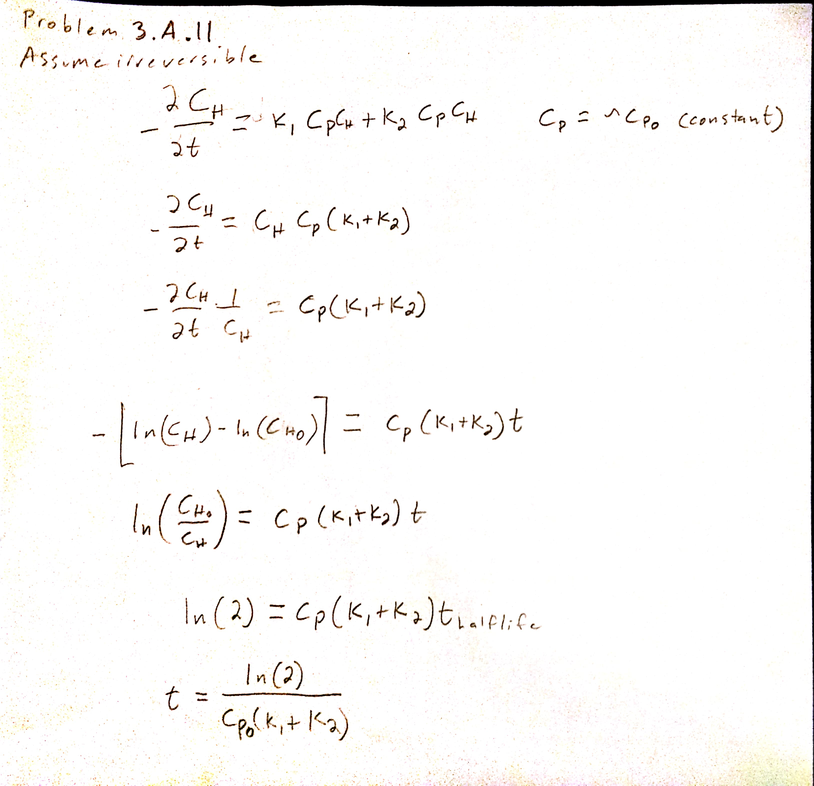

In [11]:
Image(filename='images/H_HalfLife_Calc.png') 

##### Problem 3.A.iii #####
How is the product distribution related to these two k’s?

I am a little unsure how to answer this, so I will give a qualitative answer accompanied with a flux diagram. Both of these reactions consume propane, but C2H4 formation seems to be favored if NC3H7 generation is favored. conversely, the generation of IC3H7 seems to favor the generation of C3H6, which is our desired product.

In [12]:
# look at flux diagram
Image(filename='reaction_path_C_gas.png')

Problem 3 B
------

##### Problem 3.B.i #####
Simulate the pyrolysis of pure propane at 850 K and 1000 K, for P=1 atm, in an isothermal plug flow reactor with an inlet flow velocity of 1 cm/second.Note that a much longer reactor is needed at the lower temperature.

I have run the cell below twice, once at 1000K and once at 850K, I hope it is not confusing. They took a very long time to run so I did one notebook locally and one on our cluster computing system.

In [13]:
# get chemkin file and setup reactor
cti_file = '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/propanepyrolysis.cti'
gas = ct.Solution(cti_file)

# Reactor conditions
X_Prop = 1
reactorTemperature = 1000  # Kelvin
reactorPressure = ct.one_atm
concentrations = {'propane(1)': X_Prop}
gas.TPX = reactorTemperature, reactorPressure, concentrations 
H_conc = gas['H(2)'].concentrations
H_conc_half = H_conc/2
Prop_conc = gas['propane(1)'].concentrations

#######################################################################
length = 1  # *approximate* PFR length [m]
u_0 = 0.01  # inflow velocity [m/s]
area = 1.e-4  # cross-sectional area [m**2]

# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain
# of 'n_steps' stirred reactors.
n_steps = 500
#####################################################################

mass_flow_rate = u_0 * gas.density * area
dz = length / n_steps
r_vol = area * dz

#initialize reactor
atol = 1e-20
rtol = 1e-7
r1 = ct.IdealGasReactor(contents=gas, energy='off', name='PFR')
r1.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r1, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r1, downstream, master=m, K=1e-5)


print(Prop_conc)

# Initialize reactor network
sim = ct.ReactorNet([r1])
sim.atol = atol
sim.rtol = rtol

#add sensitive reactions
for i in range(gas.n_reactions):
     r1.add_sensitivity_reaction(i)

# approximate a time step to achieve a similar resolution as in the next method
t_total = length / u_0
dt = t_total / n_steps
# define time, space, and other information vectors
z1 = (np.arange(n_steps) + 1) * dz
t_r1 = np.zeros_like(z1)  # residence time in each reactor
t1 = (np.arange(n_steps) + 1) * dt
z1 = np.zeros_like(t1)
u1 = np.zeros_like(t1)
states1 = ct.SolutionArray(r1.thermo)

#check initial concentration
print(*gas['propane(1)'].X)

[0.0121866]
1.0


In [14]:
# Create output files for sim that we can read in later:
outfile = open('results_propane','w')
outfile2 = open('results_propane_ROP','w')
outfile3 = open('results__propane_sensitivity', 'w')
gas_production_label = [s + ' production rate' for s in gas.species_names]
gas_concentration_label = [s + ' concentration' for s in gas.species_names]
writer = csv.writer(outfile)
writer2 = csv.writer(outfile2)
writer3 = csv.writer(outfile3)
writer.writerow(['Time (s)'] + gas.species_names + gas_concentration_label + gas_production_label)
writer2.writerow(['Time (s)'] + gas.reactions())
writer3.writerow(['Time (s)'] + gas.reactions())

# iterate through the PFR cells
for n in range(n_steps):
    
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r1.thermo.TDY
    upstream.syncState()
    # integrate the reactor forward in time until steady state is reached
    sim.reinitialize()
    sim.advance_to_steady_state()
    # compute velocity and transform into time
    u1[n] = mass_flow_rate / area / r1.thermo.density
    t_r1[n] = r1.mass / mass_flow_rate  # residence time in this reactor
    t1[n] = np.sum(t_r1)
    # write output data
    states1.append(r1.thermo.state)

    writer.writerow([t1[n]] + list(gas.X) + list(gas.concentrations)+list(gas.net_production_rates))
    writer2.writerow([t1[n]] + list(gas.net_rates_of_progress))
    writer3.writerow([t1[n]] + [sim.sensitivity('C3H6(95)', s) for s in range(gas.n_reactions)])
    

In [129]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CH':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CH':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))

In [132]:
save_flux_diagrams(gas)

Wrote graphviz input file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_C_gas.dot'.
Wrote graphviz output file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_C_gas.png'.
Wrote graphviz input file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_H_gas.dot'.
Wrote graphviz output file to '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/Cantera Notebook/HW1_P3/reaction_path_H_gas.png'.


In [137]:
# 1000K
data = pd.read_csv('results_propane')
df = pd.DataFrame(data)
data_rop = pd.read_csv('results_propane_ROP')
df_rop = pd.DataFrame(data_rop)
data_sens = pd.read_csv('results__propane_sensitivity')
df_sens = pd.DataFrame(data_sens)

# 850K
data_850K = pd.read_csv('results_propane_850K')
df_850K = pd.DataFrame(data_850K)
data_rop_850K = pd.read_csv('results_propane_ROP_850K')
df_rop_850K = pd.DataFrame(data_rop_850K)
data_sens_850K = pd.read_csv('results_propane_sensitivity_850K')
df_sens_850K = pd.DataFrame(data_sens_850K)

In [101]:
plt = data.plot(x='Time (s)', y='propane(1)')


Problem 3 C
------

##### Problem 3.C.i #####
What is the ratio of propene/ethene produced at short times? 

See the plots below for the mole fractions and the ratio between the two, at 1000K and 850K.

<AxesSubplot:title={'center':'Ratio at 850K'}, xlabel='Time (s)', ylabel='Ratio'>

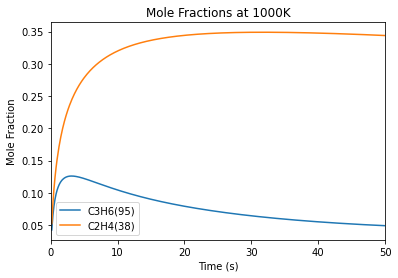

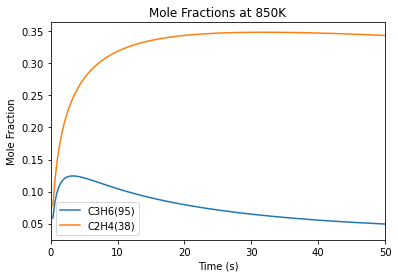

In [149]:
# at 1000 K
ax = df.plot(x='Time (s)', y='C3H6(95)', ylabel = 'Mole Fraction',xlim=[0,50], title='Mole Fractions at 1000K')
df.plot(ax=ax, x='Time (s)', y='C2H4(38)')
df['Ratio of propene to Ethene'] = df['C3H6(95)']/df['C2H4(38)']

df.plot(x='Time (s)', y='Ratio of propene to Ethene', ylabel='Ratio', xlim=[0,50], title='Ratio at 1000K')


# at 850K
ax = df_850K.plot(x='Time (s)', y='C3H6(95)', ylabel = 'Mole Fraction',xlim=[0,50], title='Mole Fractions at 850K')
df_850K.plot(ax=ax, x='Time (s)', y='C2H4(38)')
df_850K['Ratio of propene to Ethene'] = df_850K['C3H6(95)']/df_850K['C2H4(38)']

df_850K.plot(x='Time (s)', y='Ratio of propene to Ethene', ylabel='Ratio', xlim=[0,50], title='Ratio at 850K')

##### Problem 3.C.ii #####
What is the ratio at the point where the propene mole fraction reaches its peak? 

Max at 1000K  = 0.1261350817 <br>
time = 3.0762711515791694 s <br>
Ratio at 1000K = 3.0762711516 <br>

Max at 850K  = 0.1243557097 <br>
time = 3.324452719261097 s <br>
Ratio at 850K = 3.3244527193<br>


In [148]:
# at 1000K
column = df['C3H6(95)']
time = df['Time (s)']
ratio = df['Ratio of propene to Ethene']
max_value = column.max()
max_index = column.idxmax()

print("Max at 1000K  = " "{:.10f}".format(max_value),'\ntime =', time[max_index])
print("Ratio at 1000K = " "{:.10f}".format(time[max_index]))

column = df_850K['C3H6(95)']
time = df_850K['Time (s)']
ratio = df_850K['Ratio of propene to Ethene']
max_value = column.max()
max_index = column.idxmax()

print("\nMax at 850K  = " "{:.10f}".format(max_value),'\ntime =', time[max_index])
print("Ratio at 850K = " "{:.10f}".format(time[max_index]))

Max at 1000K  = 0.1261350817 
time = 3.0762711515791694
Ratio at 1000K = 3.0762711516

Max at 850K  = 0.1243557097 
time = 3.324452719261097
Ratio at 850K = 3.3244527193


##### Problem 3.C.iii #####
 Are these answers different at the two temperatures? 
 
 Yes. it is slightly higher and further along in the reactor at 850K

##### Problem 3.D.i #####
Why doesn’t the propene mole fraction keep climbing rapidly like the ethene mole fraction does? 

There is a highly favored reaction from Propene to CH3, which is consuming our Propene, which you can see in the flux diagrams below

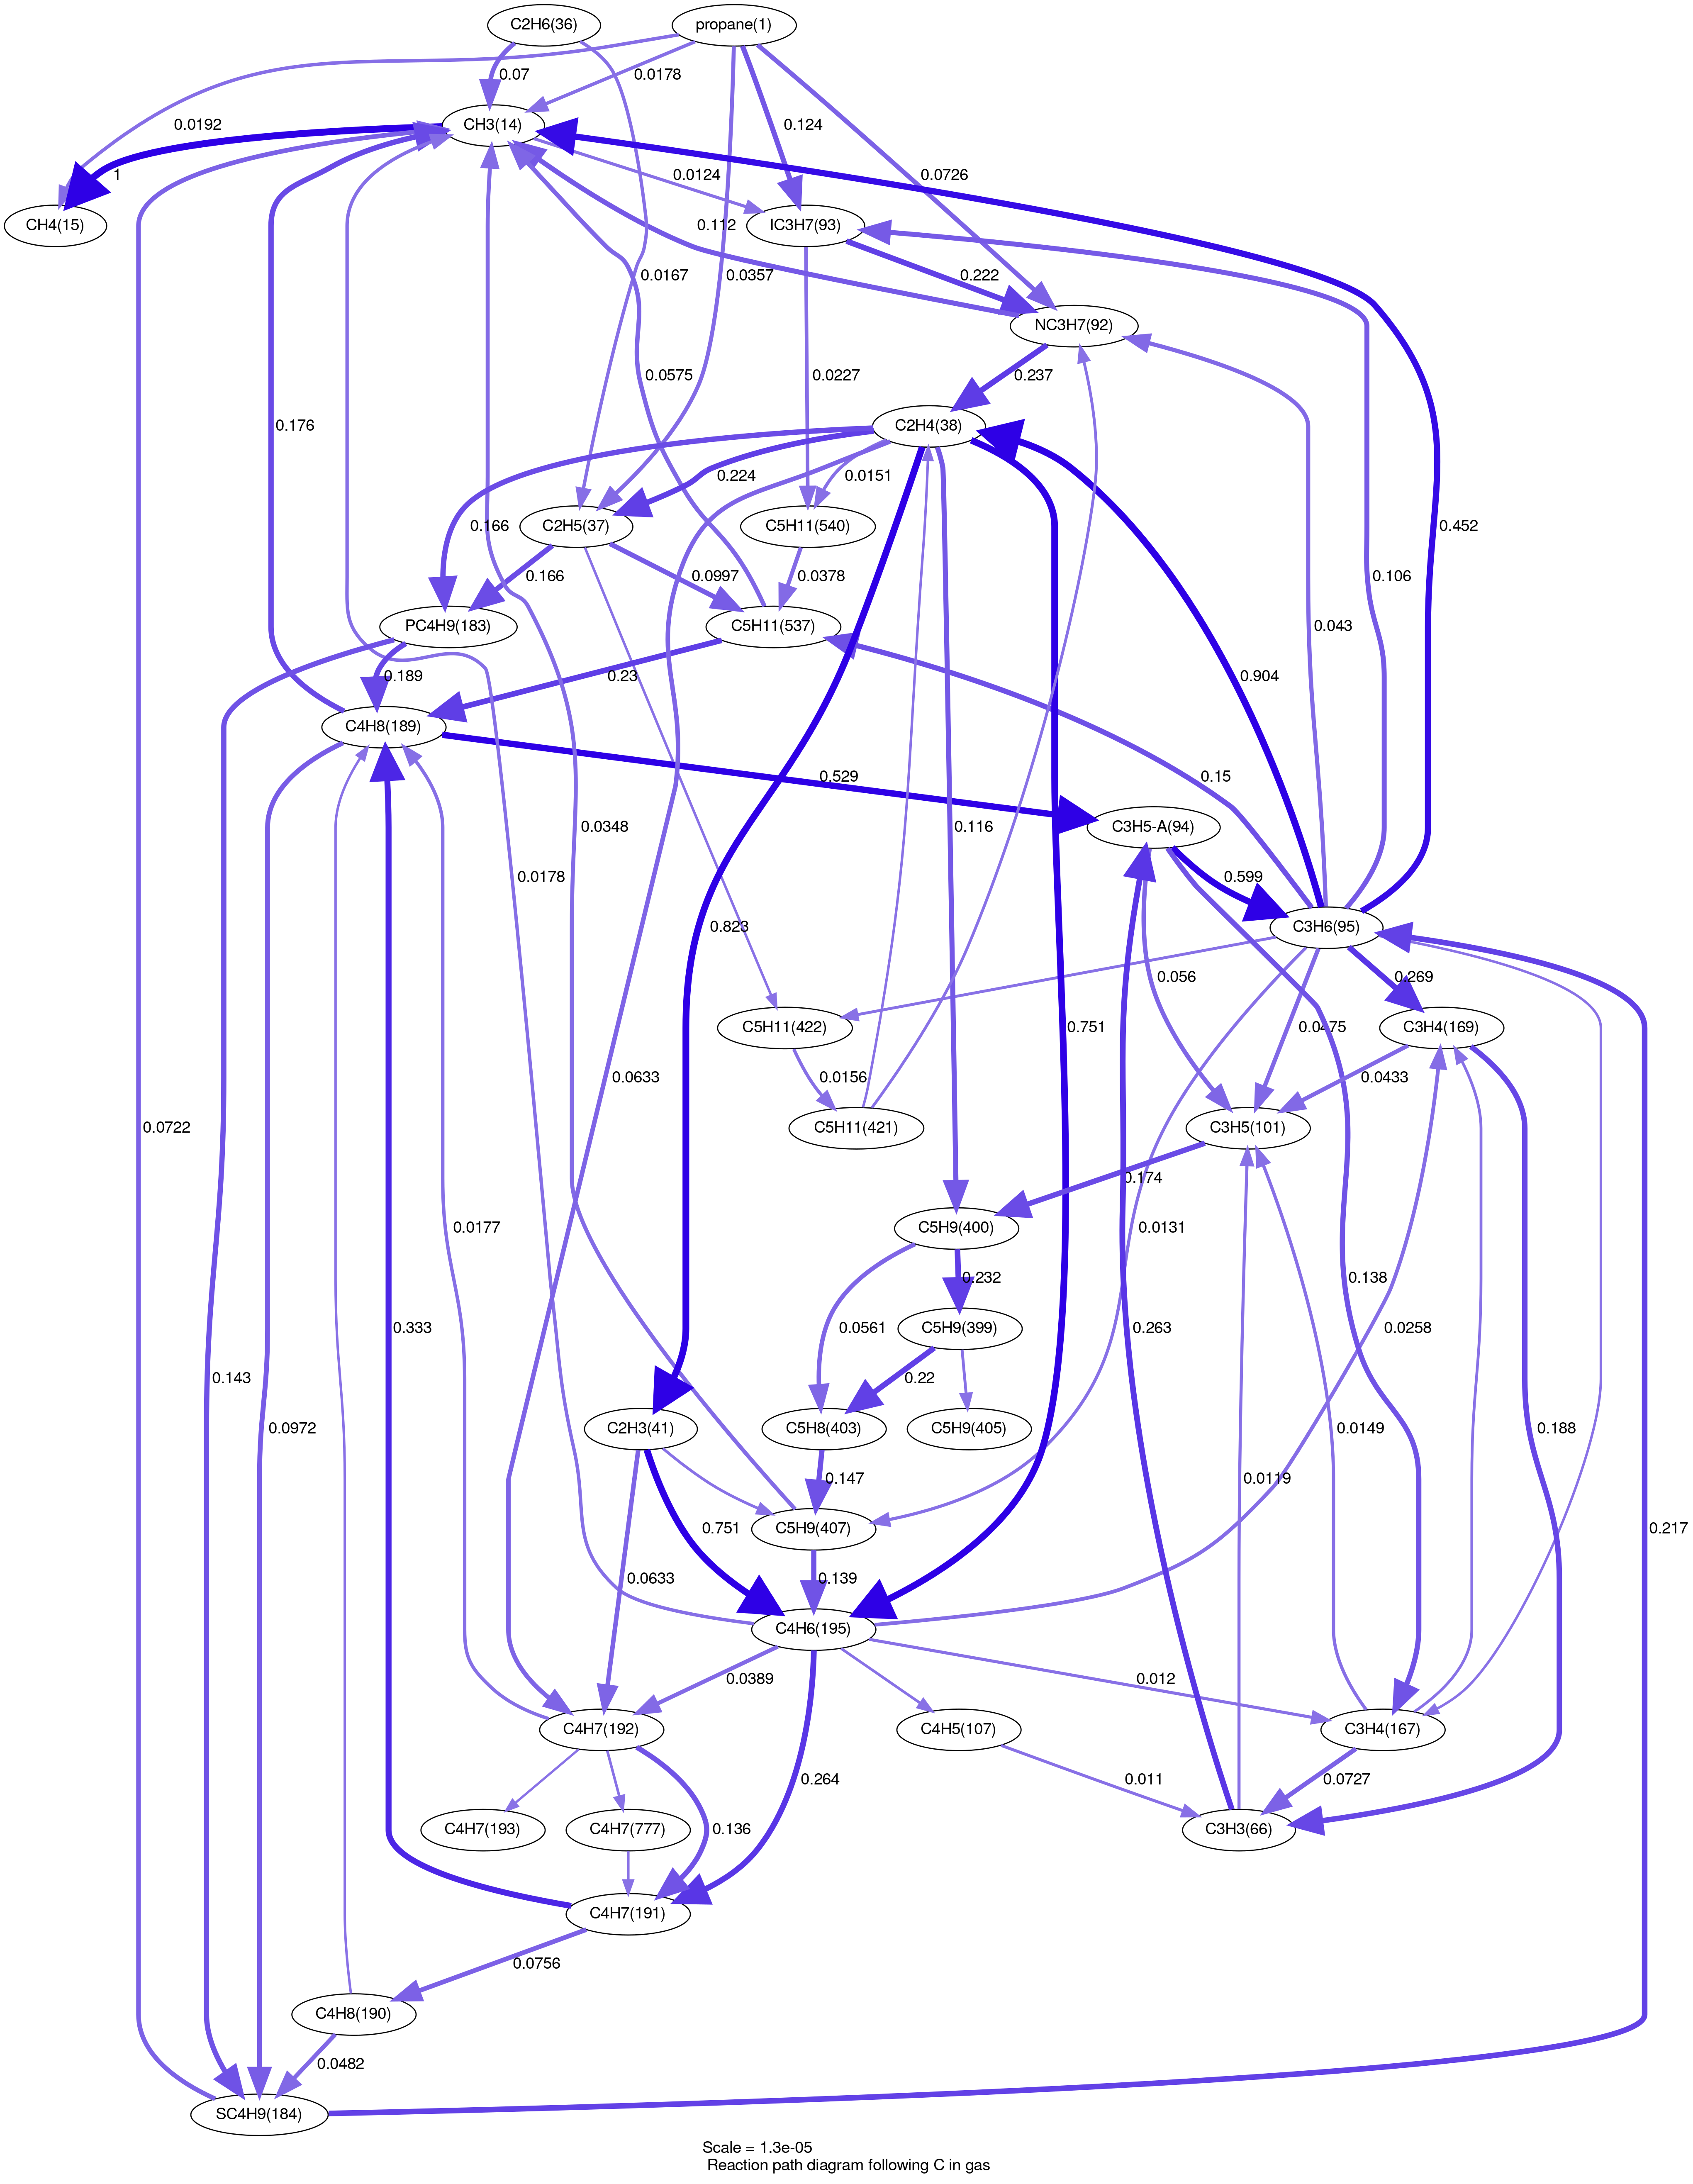

In [187]:
# look at flux disgram
Image(filename='reaction_path_C_gas_1000K.png')

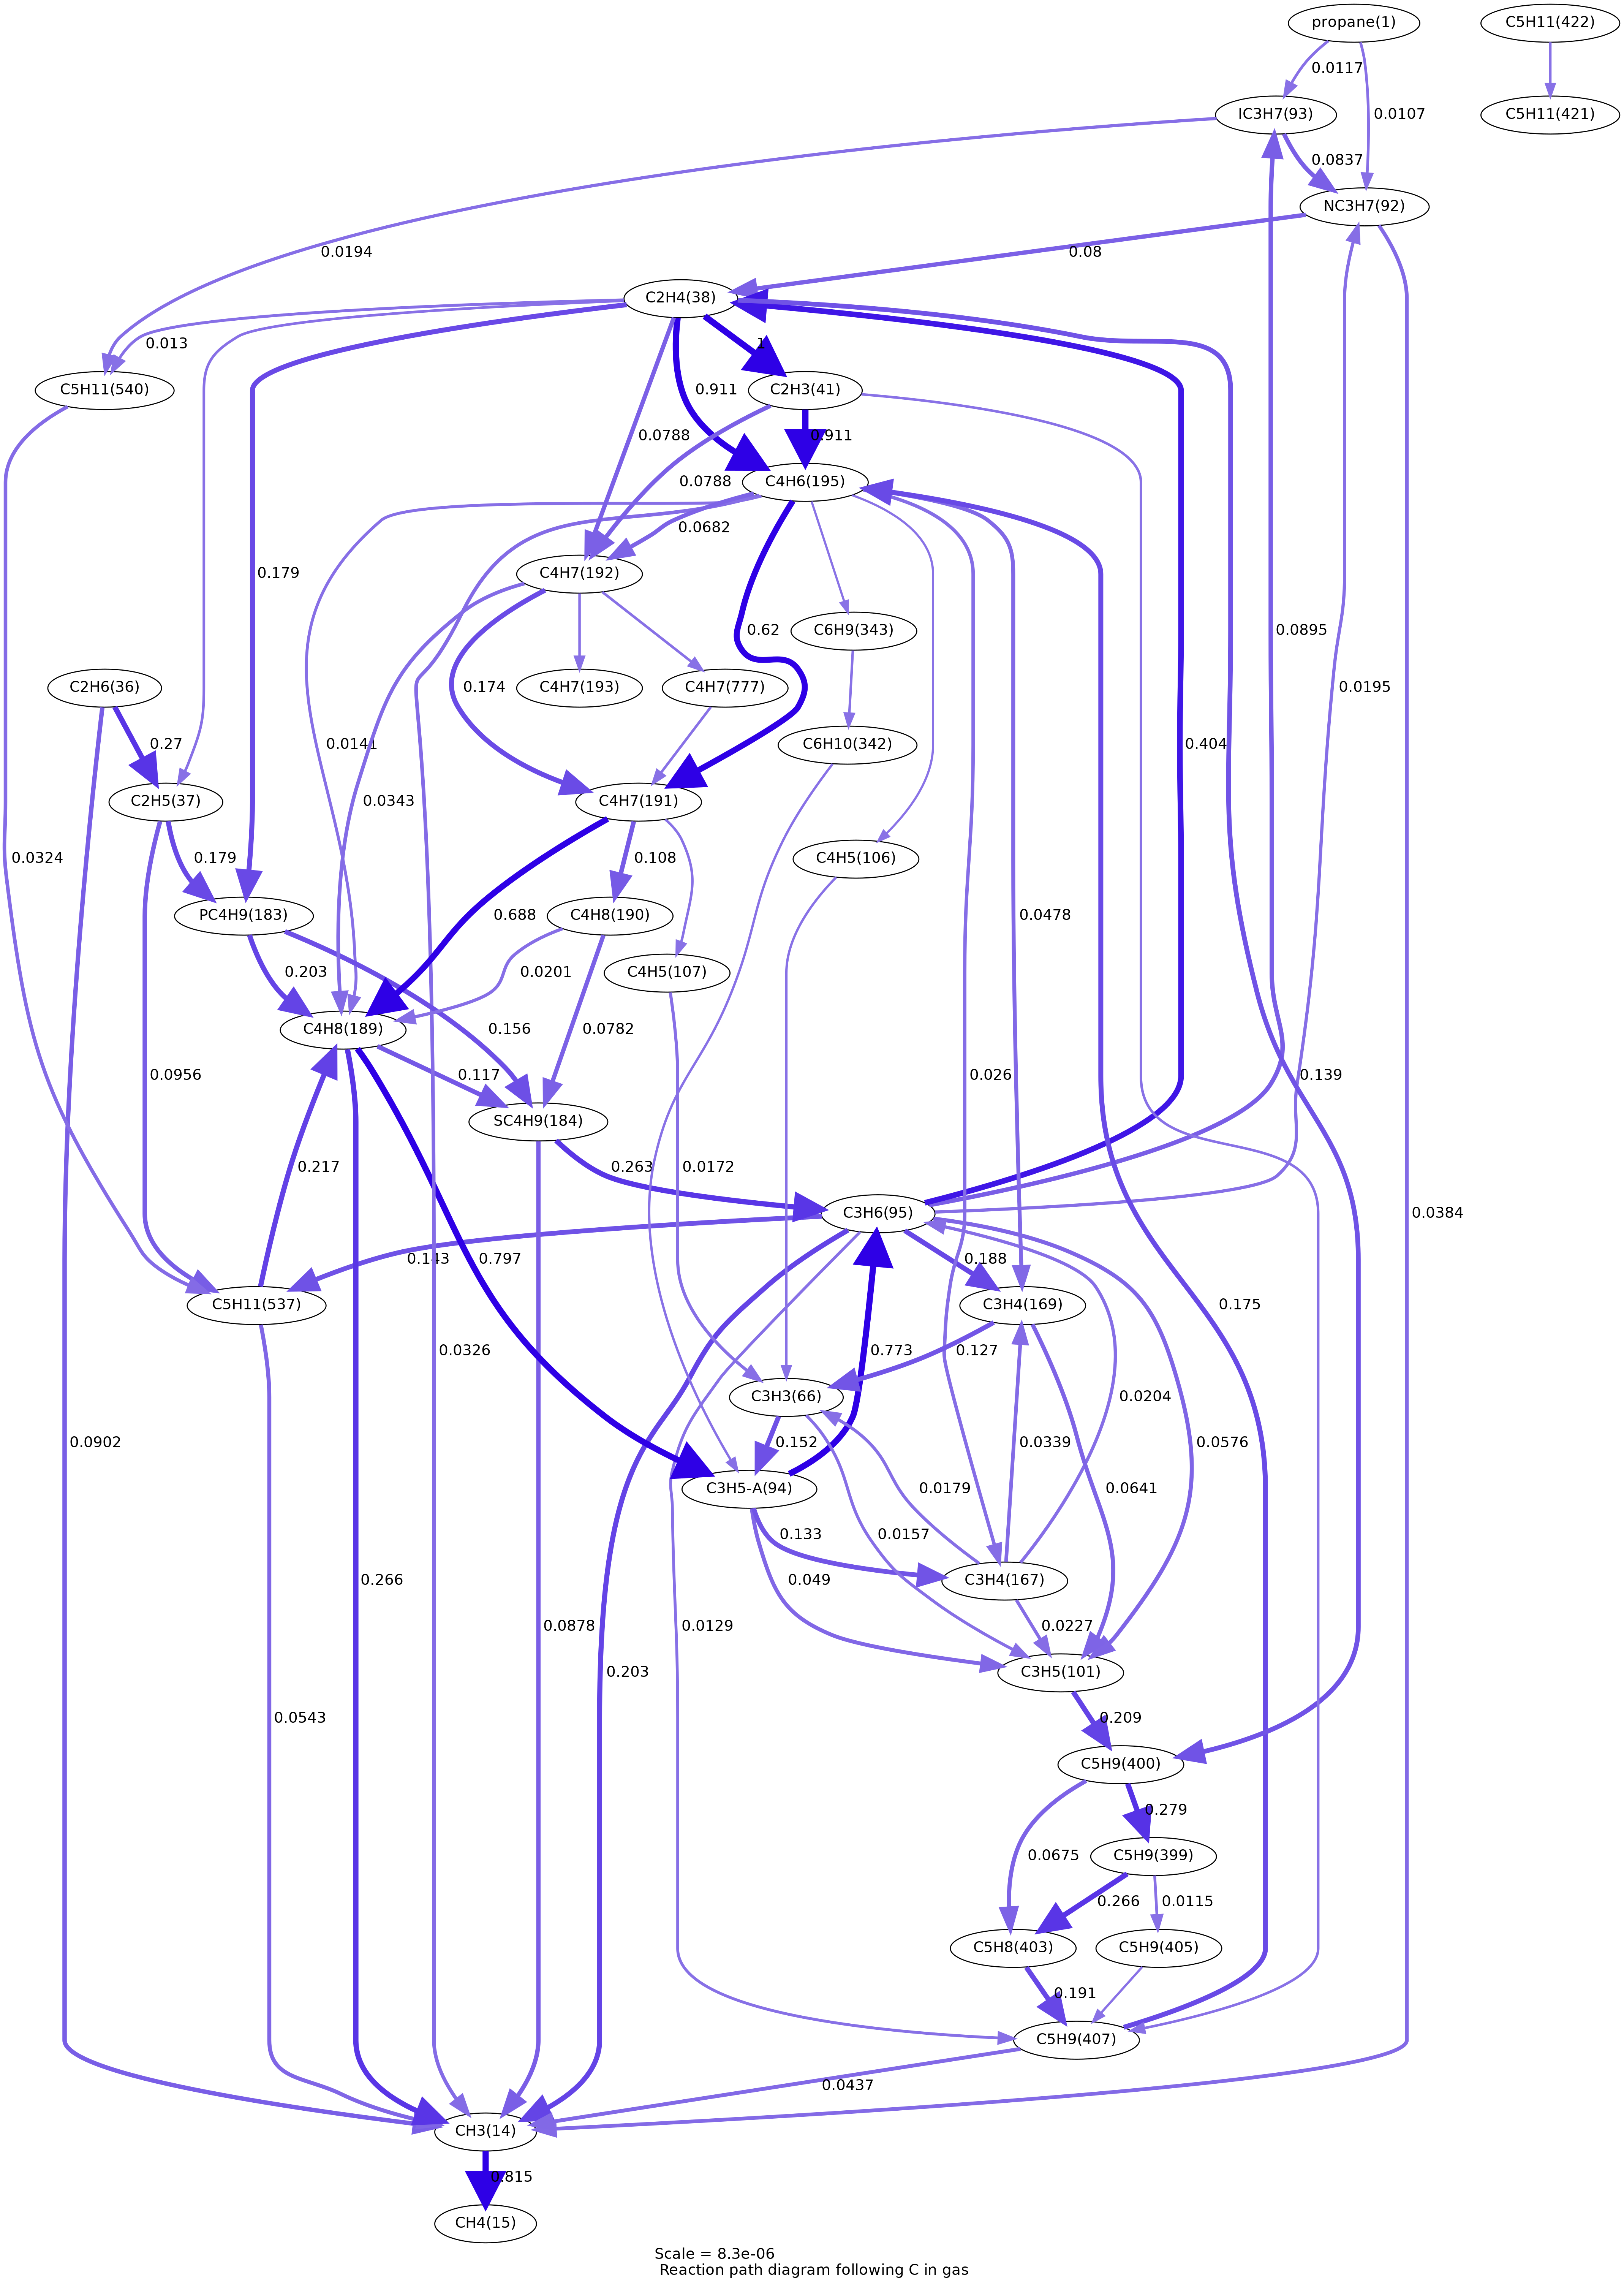

In [186]:
# Flux at 850K
Image(filename='reaction_path_C_gas_850K.png')